In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


https://github.com/nisode/MSDS/tree/main/Deep%20Learning

# Task

The goal is to categorize Twitter posts as disaster tweets or not.

Twitter posts are fast and can be useful to be monitored to spot the beginnings of a disaster.

We are given about 7.6k tweets to train our data and then to categorize on an unseen test set.

Some posts have misleading texts which can result in false flags.

# Load Data

In [2]:
train_df = pd.read_csv('../input/nlp-getting-started/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Positive target (1) means a disaster related tweet.

# EDA

Let's see what our data looks like and data types are:

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<AxesSubplot:>

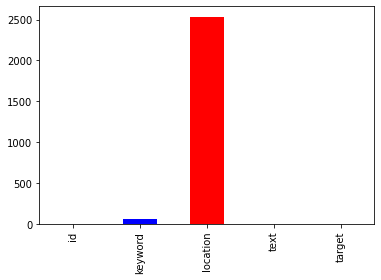

In [4]:
train_df.isnull().sum().plot(kind='bar', color=['red', 'blue'])

Checking our data columns for missing values, location has around a third of its data missing. That would make it hard for categorization so I think we won't consider using them. Keyword has a few missing as well.

In [5]:
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [7]:
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In the test data, location also has about a third of its data missing. I think I will be dropping this and keyword because I'm not sure how I would include either in a matrix of tokens.

In [8]:
import matplotlib.pyplot as plt

Let's take a look at the target value breakdown:

<AxesSubplot:ylabel='target'>

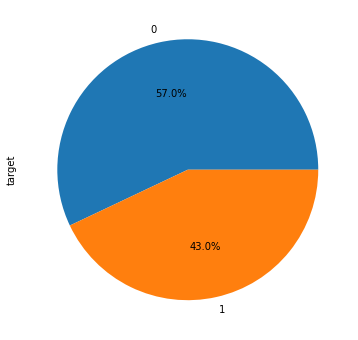

In [9]:
plt.figure(figsize=(6,6))
train_df['target'].value_counts(normalize=True).plot(kind="pie", autopct='%1.1f%%')

<AxesSubplot:>

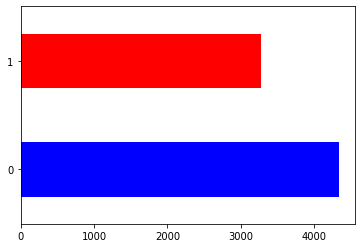

In [10]:
train_df['target'].value_counts().plot(kind='barh', color=['blue','red'])

About 57% not disaster and 43% disaster. It is a bit imbalance, but I won't worry about it this time.

In [11]:
train_df['keyword'].value_counts()[0:10]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
Name: keyword, dtype: int64

Just a look at what the keywords are and how they might be used in another attempt.

# Cleaning Data

I see a lot of notebooks use this preprocessing pipeline or something very similar, so it must be popular and effective solution to this problem. I have one of the notebooks where I found it linked in the comment section below.

It goes through a 9 step procress:

1. removes any @ tagging
2. removes any digits
3. removes any hastag symbols
4. removes links such as emails and websites
5. removes anything that doesn't start with a character
6. lower cases everything
7. removes any stopwords
8. lemmatize which turns words to their base words
9. joins it all back together

In [12]:
# preprocessPipeline base from here: https://www.kaggle.com/code/alid3bs/lstm-vs-gru-vs-bidirectional/notebook
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import nltk
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

def preprocessPipline(data, labelName):
    
    dataTemp = data.copy()
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: re.sub('(\s*)@\w+(\s*)','', x))
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: re.sub('\d+','', x))
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: re.sub('#','', x))
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: re.sub('https?://\S+|www\.\S+','',x))
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: re.sub('[^A-Za-z]',' ',x))
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: x.lower())
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x : [word for word in x.split()  if word not in stop_words])
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: ' '.join(x))
    return dataTemp

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [13]:
train_df_cleaned = preprocessPipline(train_df, "text")
clean_text = train_df_cleaned['text']
clean_text[0:5]

0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident asked shelter place notified officer ...
3    people receive wildfire evacuation order calif...
4    got sent photo ruby alaska smoke wildfire pour...
Name: text, dtype: object

# Preparing Data

Using tokenizer, we will turn the token counts into integer sequences to represent the order of words in the twitter posts with respect to the token in the tokenizer dictionary. Then padding makes it so all the sequences are the same length as the longest one.

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token="unk")
tokenizer.fit_on_texts(clean_text)
X = tokenizer.texts_to_sequences(clean_text)

X = pad_sequences(X, padding='post',truncating='post')
X

array([[3890,  486,  163, ...,    0,    0,    0],
       [ 108,    2,  146, ...,    0,    0,    0],
       [1515, 1401, 1681, ...,    0,    0,    0],
       ...,
       [ 631,  524,  417, ...,    0,    0,    0],
       [  19,  993,  393, ...,    0,    0,    0],
       [ 130,   18,  443, ...,    0,    0,    0]], dtype=int32)

In [15]:
X.shape

(7613, 23)

We can see the longest post (minus stopwords) is 23 tokens long.

We put the targets as their own series and split the data into train and validation set by 0.2 and keeping a proportional amount of Y.

In [16]:
Y = train_df_cleaned['target']
Y 

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_val ,y_train ,y_val = train_test_split(X, Y, test_size=0.2, stratify=Y)
x_train.shape

(6090, 23)

In [18]:
vocab_size = len(tokenizer.word_index)
vocab_size

12811

# Model Architecture

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Some explanations for architecture choices:
1. embedding apparently needs vocab_size + 1 according to keras documentation
2. relus seem to work good previously, so I will be reusing them
3. sigmoid with 1 output in the output layer because it is a binary classification problem
3. Adam seems to work well in general so this will also be reused.
4. I will be tuning number of hidden layers, drop out thresholds, and learning rates
6. Will try versions where lstm is bidirectional and versions where it is not
7. I pick LSTM for this problem, because sentences can be seen as time series data and it can help us deal with any vanishing gradient problems

In [20]:
lstm_model1 = Sequential([
    layers.Embedding(vocab_size + 1,64),
    Dropout(0.2),
    layers.LSTM(64),
    Dense(23, activation = 'relu'),
    Dropout(0.2),
    Dense(23, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

lstm_model1.compile(optimizer = Adam(learning_rate=0.001),
                    loss="binary_crossentropy", 
                    metrics = ['accuracy', tf.keras.metrics.AUC()])

lstm_model1.summary()

2022-08-16 13:04:22.568660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 13:04:22.720625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 13:04:22.721487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 13:04:22.722972: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          819968    
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 23)                1495      
_________________________________________________________________
dropout_1 (Dropout)          (None, 23)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 23)                552       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

# Results

In [21]:
lstm_model1_hist = lstm_model1.fit(x = x_train,
                                   y = y_train,
                                   validation_data = (x_val, y_val),
                                   epochs = 10,
                                   verbose = 1)

Epoch 1/10


2022-08-16 13:04:26.029081: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-16 13:04:28.971934: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


191/191 [==============================] - 6s 9ms/step - loss: 0.5629 - accuracy: 0.7010 - auc: 0.7603 - val_loss: 0.4855 - val_accuracy: 0.7919 - val_auc: 0.8613
Epoch 2/10
191/191 [==============================] - 2s 8ms/step - loss: 0.3333 - accuracy: 0.8722 - auc: 0.9232 - val_loss: 0.4457 - val_accuracy: 0.7932 - val_auc: 0.8638
Epoch 3/10
191/191 [==============================] - 1s 6ms/step - loss: 0.2109 - accuracy: 0.9266 - auc: 0.9643 - val_loss: 0.5027 - val_accuracy: 0.7669 - val_auc: 0.8483
Epoch 4/10
191/191 [==============================] - 1s 6ms/step - loss: 0.1534 - accuracy: 0.9519 - auc: 0.9792 - val_loss: 0.7110 - val_accuracy: 0.7676 - val_auc: 0.8432
Epoch 5/10
191/191 [==============================] - 1s 6ms/step - loss: 0.1151 - accuracy: 0.9635 - auc: 0.9851 - val_loss: 0.7609 - val_accuracy: 0.7761 - val_auc: 0.8213
Epoch 6/10
191/191 [==============================] - 1s 6ms/step - loss: 0.1001 - accuracy: 0.9665 - auc: 0.9879 - val_loss: 0.7538 - val_ac

In [22]:
def metrics_plot(history):
    xs = np.arange(1, len(history['loss'])+1)
    plt.figure(figsize=[16,4])
    
    plt.subplot(1,3,1)
    plt.plot(xs, history['loss'], label='Training')
    plt.plot(xs, history['val_loss'], label='Validation')
    plt.xlabel('Epoch') 
    plt.ylabel('Loss') 
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(xs, history['accuracy'], label='Training')
    plt.plot(xs, history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch') 
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.plot(xs, history[list(history.keys())[2]], label='Training')
    plt.plot(xs, history[list(history.keys())[5]], label='Validation')
    plt.xlabel('Epoch') 
    plt.ylabel('AUC') 
    plt.title('AUC')
    plt.legend()
    plt.tight_layout()
    
    plt.show()

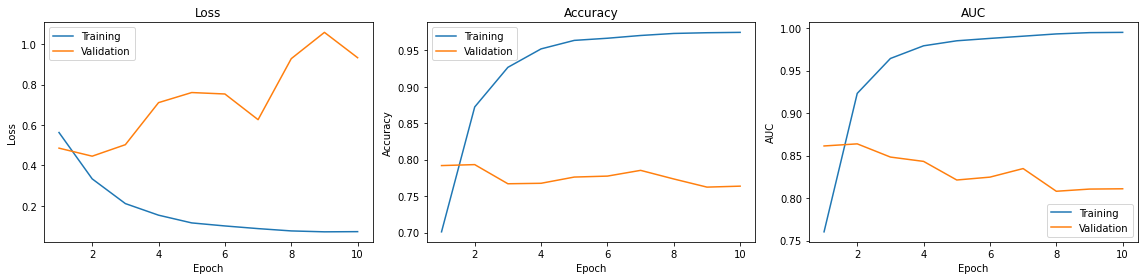

In [23]:
metrics_plot(lstm_model1_hist.history)

In [24]:
lstm_model2 = Sequential([
    layers.Embedding(vocab_size + 1,64),
    Dropout(0.5),
    layers.LSTM(64),
    Dense(23, activation = 'relu'),
    Dropout(0.5),
    Dense(23, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

lstm_model2.compile(optimizer = Adam(learning_rate=0.001),
                    loss="binary_crossentropy", 
                    metrics = ['accuracy', tf.keras.metrics.AUC()])

lstm_model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          819968    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 23)                1495      
_________________________________________________________________
dropout_3 (Dropout)          (None, 23)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 23)                552       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [25]:
lstm_model2_hist = lstm_model2.fit(x = x_train,
                                   y = y_train,
                                   validation_data = (x_val, y_val),
                                   epochs = 10,
                                   verbose = 1)

Epoch 1/10
191/191 [==============================] - 3s 9ms/step - loss: 0.6481 - accuracy: 0.6176 - auc_1: 0.6235 - val_loss: 0.4785 - val_accuracy: 0.7846 - val_auc_1: 0.8446
Epoch 2/10
191/191 [==============================] - 1s 6ms/step - loss: 0.4280 - accuracy: 0.8287 - auc_1: 0.8734 - val_loss: 0.4418 - val_accuracy: 0.8011 - val_auc_1: 0.8670
Epoch 3/10
191/191 [==============================] - 1s 6ms/step - loss: 0.2990 - accuracy: 0.8888 - auc_1: 0.9369 - val_loss: 0.4917 - val_accuracy: 0.7984 - val_auc_1: 0.8623
Epoch 4/10
191/191 [==============================] - 1s 6ms/step - loss: 0.2265 - accuracy: 0.9256 - auc_1: 0.9606 - val_loss: 0.5010 - val_accuracy: 0.7905 - val_auc_1: 0.8572
Epoch 5/10
191/191 [==============================] - 1s 6ms/step - loss: 0.1778 - accuracy: 0.9443 - auc_1: 0.9731 - val_loss: 0.5130 - val_accuracy: 0.7945 - val_auc_1: 0.8537
Epoch 6/10
191/191 [==============================] - 1s 6ms/step - loss: 0.1450 - accuracy: 0.9544 - auc_1: 0

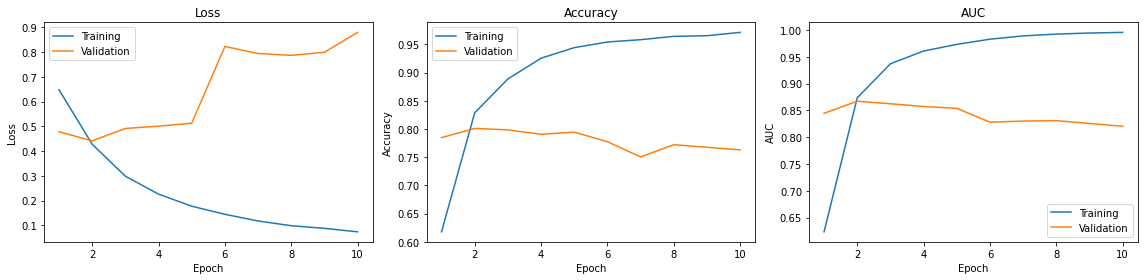

In [26]:
metrics_plot(lstm_model2_hist.history)

In [27]:
lstm_model3 = Sequential([
    layers.Embedding(vocab_size + 1,64),
    Dropout(0.5),
    layers.LSTM(64),
    Dense(23, activation = 'relu'),
    Dropout(0.5),
    Dense(23, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

lstm_model3.compile(optimizer = Adam(learning_rate=0.0001),
                    loss="binary_crossentropy", 
                    metrics = ['accuracy', tf.keras.metrics.AUC()])

lstm_model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          819968    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 23)                1495      
_________________________________________________________________
dropout_5 (Dropout)          (None, 23)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 23)                552       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [28]:
lstm_model3_hist = lstm_model3.fit(x = x_train,
                                   y = y_train,
                                   validation_data = (x_val, y_val),
                                   epochs = 10,
                                   verbose = 1)

Epoch 1/10
191/191 [==============================] - 3s 9ms/step - loss: 0.6874 - accuracy: 0.5626 - auc_2: 0.5058 - val_loss: 0.6824 - val_accuracy: 0.5706 - val_auc_2: 0.5956
Epoch 2/10
191/191 [==============================] - 1s 6ms/step - loss: 0.6781 - accuracy: 0.5703 - auc_2: 0.5510 - val_loss: 0.6459 - val_accuracy: 0.5706 - val_auc_2: 0.7510
Epoch 3/10
191/191 [==============================] - 1s 8ms/step - loss: 0.5466 - accuracy: 0.7461 - auc_2: 0.8127 - val_loss: 0.4828 - val_accuracy: 0.7840 - val_auc_2: 0.8524
Epoch 4/10
191/191 [==============================] - 1s 6ms/step - loss: 0.4200 - accuracy: 0.8365 - auc_2: 0.8796 - val_loss: 0.4532 - val_accuracy: 0.7978 - val_auc_2: 0.8606
Epoch 5/10
191/191 [==============================] - 1s 6ms/step - loss: 0.3602 - accuracy: 0.8626 - auc_2: 0.9104 - val_loss: 0.4578 - val_accuracy: 0.7978 - val_auc_2: 0.8618
Epoch 6/10
191/191 [==============================] - 1s 6ms/step - loss: 0.3274 - accuracy: 0.8803 - auc_2: 0

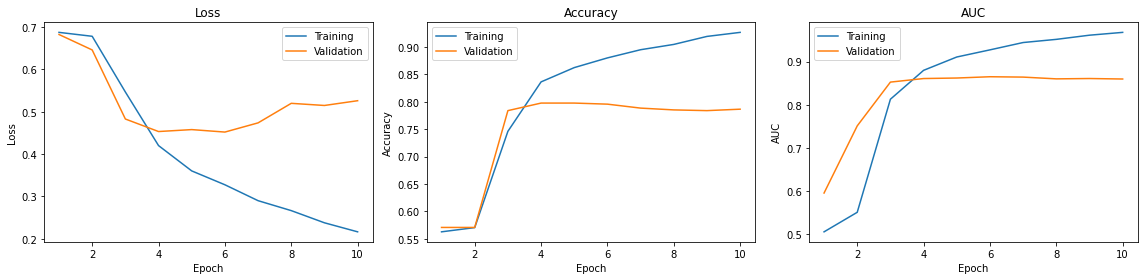

In [29]:
metrics_plot(lstm_model3_hist.history)

In [30]:
lstm_model4 = Sequential([
    layers.Embedding(vocab_size + 1,64),
    Dropout(0.2),
    layers.LSTM(64),
    Dense(23, activation = 'relu'),
    Dropout(0.2),
    Dense(23, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

lstm_model4.compile(optimizer = Adam(learning_rate=0.0001),
                    loss="binary_crossentropy", 
                    metrics = ['accuracy', tf.keras.metrics.AUC()])

lstm_model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          819968    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_9 (Dense)              (None, 23)                1495      
_________________________________________________________________
dropout_7 (Dropout)          (None, 23)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 23)                552       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [31]:
lstm_model4_hist = lstm_model4.fit(x = x_train,
                                   y = y_train,
                                   validation_data = (x_val, y_val),
                                   epochs = 10,
                                   verbose = 1)

Epoch 1/10
191/191 [==============================] - 4s 9ms/step - loss: 0.6859 - accuracy: 0.5703 - auc_3: 0.5024 - val_loss: 0.6804 - val_accuracy: 0.5706 - val_auc_3: 0.6121
Epoch 2/10
191/191 [==============================] - 1s 6ms/step - loss: 0.6555 - accuracy: 0.5941 - auc_3: 0.6694 - val_loss: 0.5763 - val_accuracy: 0.7636 - val_auc_3: 0.8312
Epoch 3/10
191/191 [==============================] - 1s 6ms/step - loss: 0.4751 - accuracy: 0.8222 - auc_3: 0.8703 - val_loss: 0.4771 - val_accuracy: 0.7879 - val_auc_3: 0.8494
Epoch 4/10
191/191 [==============================] - 1s 6ms/step - loss: 0.3432 - accuracy: 0.8675 - auc_3: 0.9226 - val_loss: 0.4730 - val_accuracy: 0.7971 - val_auc_3: 0.8540
Epoch 5/10
191/191 [==============================] - 1s 6ms/step - loss: 0.2766 - accuracy: 0.9026 - auc_3: 0.9466 - val_loss: 0.5238 - val_accuracy: 0.7702 - val_auc_3: 0.8539
Epoch 6/10
191/191 [==============================] - 1s 6ms/step - loss: 0.2209 - accuracy: 0.9268 - auc_3: 0

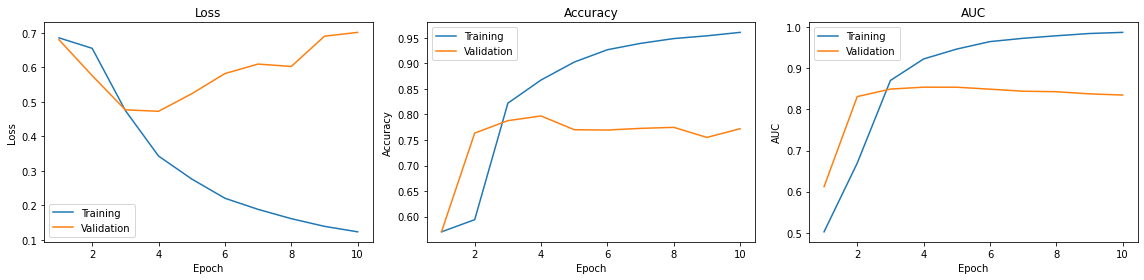

In [32]:
metrics_plot(lstm_model4_hist.history)

In [33]:
lstm_model5 = Sequential([
    layers.Embedding(vocab_size + 1,64),
    Dropout(0.2),
    layers.LSTM(64),
    Dense(23, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

lstm_model5.compile(optimizer = Adam(learning_rate=0.0001),
                    loss="binary_crossentropy", 
                    metrics = ['accuracy', tf.keras.metrics.AUC()])

lstm_model5.summary()

lstm_model5_hist = lstm_model5.fit(x = x_train,
                                   y = y_train,
                                   validation_data = (x_val, y_val),
                                   epochs = 10,
                                   verbose = 1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          819968    
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_12 (Dense)             (None, 23)                1495      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 24        
Total params: 854,511
Trainable params: 854,511
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [==============================] - 4s 10ms/step - loss: 0.6834 - accuracy: 0.5704 - auc_4: 0.52

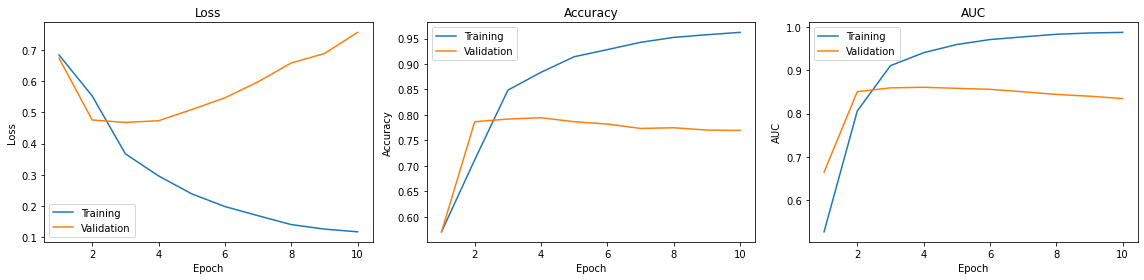

In [34]:
metrics_plot(lstm_model5_hist.history)

So far these results have not been very interesting. There isn't much variation in results, but let's try to see if it's different if we make the lstm bidirectional.

In [35]:
bid_model1 = Sequential([
    layers.Embedding(vocab_size + 1,128),
    Dropout(0.2),
    layers.Bidirectional(layers.LSTM(64)),
    Dense(23, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

bid_model1.compile(optimizer = Adam(learning_rate=0.0001),
                    loss="binary_crossentropy", 
                    metrics = ['accuracy', tf.keras.metrics.AUC()])

bid_model1.summary()

bid_model1_hist = bid_model1.fit(x = x_train,
                                   y = y_train,
                                   validation_data = (x_val, y_val),
                                   epochs = 10,
                                 verbose = 1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         1639936   
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_14 (Dense)             (None, 23)                2967      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 24        
Total params: 1,741,743
Trainable params: 1,741,743
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [==============================] - 5s 12ms/step - loss: 0.6801 - accuracy: 0.5645 - auc_5: 

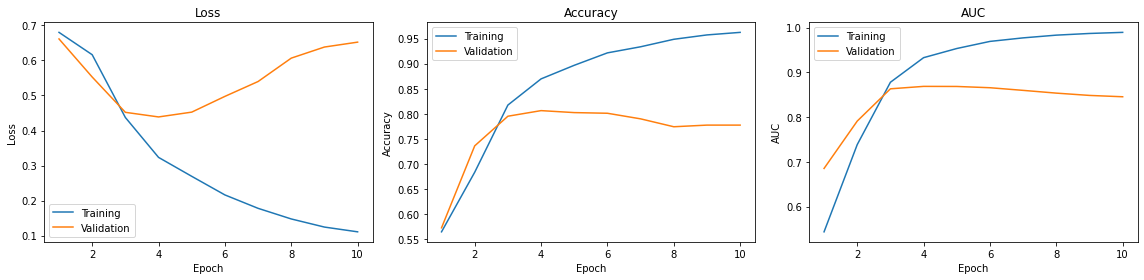

In [36]:
metrics_plot(bid_model1_hist.history)

In [37]:
bid_model2 = Sequential([
    layers.Embedding(vocab_size + 1,128),
    Dropout(0.5),
    layers.Bidirectional(layers.LSTM(64)),
    Dense(1, activation = 'sigmoid')
])

bid_model2.compile(optimizer = Adam(learning_rate=0.0001),
                    loss="binary_crossentropy", 
                    metrics = ['accuracy', tf.keras.metrics.AUC()])

bid_model2.summary()

bid_model2_hist = bid_model2.fit(x = x_train,
                                   y = y_train,
                                   validation_data = (x_val, y_val),
                                   epochs = 10,
                                 verbose = 1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         1639936   
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total params: 1,738,881
Trainable params: 1,738,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [==============================] - 5s 12ms/step - loss: 0.6791 - accuracy: 0.5675 - auc_6: 0.5510 - val_loss: 0.6685 - val_accuracy: 0.5706 - val_auc_6: 0.6534
Epoch 2/10
191/191 [==============================] - 1s 8ms/st

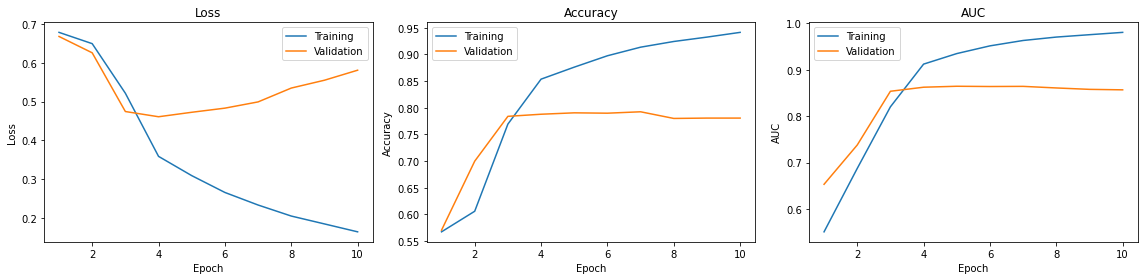

In [38]:
metrics_plot(bid_model2_hist.history)

In [39]:
bid_model3 = Sequential([
    layers.Embedding(vocab_size + 1,128),
    Dropout(0.5),
    layers.Bidirectional(layers.LSTM(64)),
    Dense(1, activation = 'sigmoid')
])

bid_model3.compile(optimizer = Adam(learning_rate=0.001),
                    loss="binary_crossentropy", 
                    metrics = ['accuracy', tf.keras.metrics.AUC()])

bid_model3.summary()

bid_model3_hist = bid_model3.fit(x = x_train,
                                 y = y_train,
                                 validation_data = (x_val, y_val),
                                 epochs = 10,
                                 verbose = 1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         1639936   
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 1,738,881
Trainable params: 1,738,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [==============================] - 6s 14ms/step - loss: 0.5516 - accuracy: 0.7159 - auc_7: 0.7790 - val_loss: 0.4440 - val_accuracy: 0.8043 - val_auc_7: 0.8691
Epoch 2/10
191/191 [==============================] - 1s 8ms/st

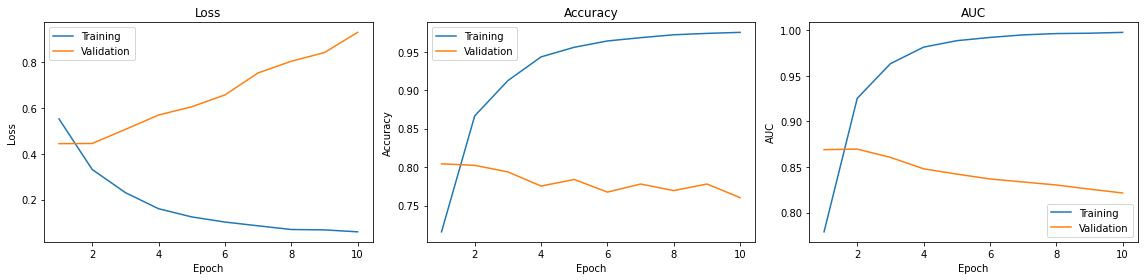

In [40]:
metrics_plot(bid_model3_hist.history)

I ran every model for 10 epochs. This runs much much faster than the cancer image set. The first epoch was always slowest, but even then it was multitudes faster. Here are the results if I were to stop at the highest validation accuracy. Disappointingly, they didn't seem to vary all that much from 79% validation accuracy. The best performing model seems to be the last model, but that was also at the first epoch. The learning rates that were one magnitude lower at 0.0001 were a lot more stable at reaching around 0.79 than the higher magnitude of 0.001. Train accuracy usually got very high toward the end of the epochs, but validation accuracy scores rarely saw consistent improvement. Instead, it would usally drop off very early in the epochs and you can see this in the metric graphs for every model. This likely means that model overfits to the data and overfits it fast. There seems to be a very slight improvement in validation accuracy with the bidirection model when compared to the non bidirection lstms. With scores this close it's hard to tell which direction to head, especially with 8 models run with varying hyper parameters. It is notable that the bidirectional models had double the parameters usually because of how I was encoding the embedded. Maybe a diffirent architechture would do better.

| model | type | drop_out | learning rate | train_acc | val_acc | val_auc
| ---- | ---- | ---- | ---- | --- | --- | --- | 
| lstm_model1 | 2 Hidden | 0.2 | 0.001 | 0.8713 | 0.7905 | 0.8514 |
| lstm_model2 | 2 Hidden | 0.5 | 0.001 | 0.8997 | 0.7814 | 0.8478 |
| lstm_model3 | 2 Hidden | 0.5 | 0.0001 | 0.8568 | 0.7866 | 0.8498 |
| lstm_model4 | 2 Hidden | 0.2 | 0.0001 | 0.9112 | 0.7859 | 0.8495 |
| lstm_model5 | 1 Hidden | 0.2 | 0.0001 | 0.9039 | 0.7919 | 0.850 |
| bid_model1 | 1 Hidden | 0.2 | 0.0001 | 0.8363 | 0.7951 | 0.8540 |
| bid_model2 | 1 Hidden | 0.5 | 0.0001 | 0.8747 | 0.7938 | 0.8580 |
| bid_model3 | 1 Hidden | 0.5 | 0.001 | 0.7223 | 0.7965 | 0.8556 |

# Conclusion

In [41]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
bid_model1 = Sequential([
    layers.Embedding(vocab_size + 1,128),
    Dropout(0.2),
    layers.Bidirectional(layers.LSTM(64)),
    Dense(23, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

bid_model1.compile(optimizer = Adam(learning_rate=0.0001),
                    loss="binary_crossentropy", 
                    metrics = ['accuracy', tf.keras.metrics.AUC()])

bid_model1.summary()

bid_model1_hist = bid_model1.fit(x = x_train,
                                 y = y_train,
                                 validation_data = (x_val, y_val),
                                 epochs = 10,
                                 callbacks=[callback],
                                 verbose = 1)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 128)         1639936   
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_18 (Dense)             (None, 23)                2967      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 24        
Total params: 1,741,743
Trainable params: 1,741,743
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [==============================] - 5s 12ms/step - loss: 0.6784 - accuracy: 0.5703 - auc_8: 

48/48 [==============================] - 1s 2ms/step


Text(0.5, 1.0, 'Confusion Matrix')

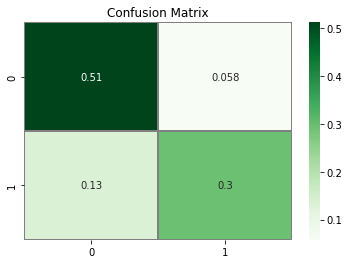

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_preds1 = bid_model1.predict(x_val, verbose=1)
y_hat_labels1 = np.round(y_preds1)
conf_mat1 = confusion_matrix(y_val, y_hat_labels1)/len(y_val)
sns.heatmap(conf_mat1, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray")
plt.title("Confusion Matrix")

I reran with early stopping for the last model which was bidirectional, since it performed best, although the difference was very slight. I had it restore the weights to the epoch that had the best validation accuracy scores. It stopped at a slightly higher validation and managed to break 0.8, but these small increases are random and aren't really good indicators. From the confusion matrix using this model, you can see that this model has a harder time predicting true positives as there seems to be a quite a lot more false negatives than false positives, nearly double the amount. It's likely that this model is bias toward predicting not disaster when it is a disaster. To improve, we need to try different architectures and perhaps try to think of a way that also includes data about the keywords.

# Create Submission

In [43]:
test_df_clean = preprocessPipline(test_df, 'text')

test_df_clean = tokenizer.texts_to_sequences(test_df_clean['text'])

test_pad = pad_sequences(test_df_clean,
                                maxlen=23, 
                                truncating='post', 
                                padding='post'
                               )

In [44]:
test_y = bid_model1.predict(test_pad, verbose=1)
test_y = np.round(test_y)

102/102 [==============================] - 0s 2ms/step


In [45]:
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
submission['target']=test_y.astype('int')
submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [46]:
submission.to_csv('submission.csv', index=False)

# References:

https://www.kaggle.com/code/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/notebook

https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

https://www.kaggle.com/code/alid3bs/lstm-vs-gru-vs-bidirectional/notebook

https://www.kaggle.com/code/danilastepochkin/disaster-tweets-dl-with-lstm-and-language-model

https://www.kaggle.com/code/ltrahul/nlp-disaster-tweets-prediction-with-nltk-and-lstm